<a href="https://colab.research.google.com/github/silentfortin/ai-portfolio/blob/main/09-genai-powerplant/genai_powerplant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CyberEye Solutions — Generative Data Augmentation for Critical Infrastructure Security

`👩‍💻 Developed as part of the AI Engineering Master – Week 9`

📌 Project Overview

This project explores generative data augmentation to improve image classification performance starting from a limited real-world–like dataset. A pipeline combining image captioning, text paraphrasing, and text-to-image generation is used to synthesize additional training images and increase dataset diversity.
The Oxford-IIIT Pet dataset serves as a controlled proxy for surveillance imagery, enabling reproducible experiments on fine-grained visual categories. A ResNet-18 and an EfficientNet-B0 classifier are trained on the original dataset and on an extended dataset enriched with synthetic images.
Model performance is evaluated on a held-out real test set using accuracy and macro-averaged precision, recall, and F1, in order to measure both overall performance and class-wise balance. This setup highlights when generative augmentation helps, when it does not, and which trade-offs emerge when adding synthetic data to critical vision pipelines.

🔗 GitHub Repository:
[ai-portfolio](https://github.com/silentfortin/ai-portfolio/)

# 1 - Imports and Reproducibility

Group all imports and set reproducibility.

In [ ]:
import os
import json
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from tqdm import tqdm

# PyTorch data/tools
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
from torchvision import transforms as T, models
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.datasets import OxfordIIITPet, ImageFolder

# transformers/diffusers (captioning, paraphrasing, generation)
from transformers import BlipProcessor, BlipForConditionalGeneration, AutoTokenizer, AutoModelForSeq2SeqLM
from diffusers import StableDiffusionPipeline

# reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


Using device: cuda


## 2 - Utility Functions


In [ ]:
class SafeTransformDataset(torch.utils.data.Dataset):
    """Apply transforms consistently to Subset/ImageFolder datasets."""
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
        self.classes = subset.dataset.classes if hasattr(subset, "dataset") else subset.classes

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
def denormalize(img_tensor):
    """
    img_tensor: Tensor [C,H,W] or Tensor [B,C,H,W]
    returns tensor on CPU in range [0,1]
    """
    if img_tensor.dim() == 4:
        den = img_tensor * std_tensor.view(1,3,1,1) + mean_tensor.view(1,3,1,1)
        return den.cpu().clamp(0,1)
    elif img_tensor.dim() == 3:
        den = img_tensor * std_tensor.view(3,1,1) + mean_tensor.view(3,1,1)
        return den.cpu().clamp(0,1)
    else:
        raise ValueError("img_tensor must be 3D or 4D tensor")

In [ ]:
def show_samples(dataset, n=4, title_prefix=""):
    """Show n samples from a dataset with class labels."""
    rows = 2
    cols = (n + 1) // 2
    fig, axs = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    axs = axs.flatten()
    for i in range(n):
        img, label = dataset[i]
        img_denorm = denormalize(img)
        axs[i].imshow(img_denorm.permute(1, 2, 0))
        axs[i].set_title(f"{title_prefix}{dataset.classes[label]}")
        axs[i].axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
def show_caption_examples(records, n=3):
    """Print a few caption + paraphrases examples."""
    for i, rec in enumerate(records[:n]):
        print(f"Example {i}")
        print(f"  Class:   {rec.get('class_name', 'N/A')}")
        print(f"  Caption: {rec.get('caption', '')}")
        for j, p in enumerate(rec.get('paraphrases', [])):
            print(f"  Paraphrase {j+1}: {p}")
        print()

In [ ]:
def evaluate(model, loader, num_classes):
    # Set model to evaluation mode
    model.eval()
    all_preds = []
    all_labels = []
    # Disable gradient calculation
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            outputs = model(images)
            # Get predicted class
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    all_preds = torch.tensor(all_preds, dtype=torch.long)
    all_labels = torch.tensor(all_labels, dtype=torch.long)

    # Initialize confusion matrix
    cm = torch.zeros(num_classes, num_classes, dtype=torch.int64)
    for t, p in zip(all_labels, all_preds):
        # Fill confusion matrix
        cm[t, p] += 1

    # Small value to avoid division by zero
    eps = 1e-8
    precision_per_class = cm.diag().float() / (cm.sum(dim=0).float() + eps)
    recall_per_class = cm.diag().float() / (cm.sum(dim=1).float() + eps)
    f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + eps)

    accuracy = (cm.diag().sum().float() / (cm.sum().float() + eps)).item()
    macro_precision = precision_per_class.mean().item()
    macro_recall = recall_per_class.mean().item()
    macro_f1 = f1_per_class.mean().item()

    return {
        'accuracy': accuracy,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'confusion_matrix': cm.numpy()
    }

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs, train_size, num_classes):
    # store training history for plotting
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        # update learning rate scheduler
        if scheduler is not None:
            scheduler.step()

        # compute average loss and accuracy on training set
        avg_train_loss = train_loss / train_size
        train_acc = correct / total

        # evaluate on validation set (accuracy only)
        val_metrics = evaluate(model, val_loader, num_classes=num_classes)
        val_acc = val_metrics["accuracy"]

        # save metrics to history
        history["train_loss"].append(avg_train_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        # epoch summary
        print(
            f'Epoch {epoch}: '
            f'Train Loss={avg_train_loss:.4f}, '
            f'Train Acc={train_acc:.4f}, '
            f'Val Acc={val_acc:.4f}'
        )

    return history

In [ ]:
def print_full_metrics(name, metrics):
    """accuracy, macro precision, recall and F1."""
    print("\n")
    print(name)
    print(f"  Accuracy:        {metrics['accuracy']:.4f}")
    print(f"  Macro Precision: {metrics['macro_precision']:.4f}")
    print(f"  Macro Recall:    {metrics['macro_recall']:.4f}")
    print(f"  Macro F1:        {metrics['macro_f1']:.4f}")
    print()

In [ ]:
def plot_training_curves(history_dict, title_prefix=""):
    """
    Plot training loss and accuracy curves for one or more models.

    history_dict: dict with entries like
      - 'Baseline': history_baseline
      - 'Extended': history_extended
    each history must contain 'train_loss', 'train_acc', 'val_acc'.
    """
    plt.figure(figsize=(12,4))

    # Loss subplot
    plt.subplot(1, 2, 1)
    for name, hist in history_dict.items():
        epochs = range(len(hist["train_loss"]))
        # plot training loss for each model
        plt.plot(epochs, hist["train_loss"], label=f"{name} Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix}Training Loss")
    plt.legend()

    # Accuracy subplot
    plt.subplot(1, 2, 2)
    for name, hist in history_dict.items():
        epochs = range(len(hist["train_acc"]))
        # plot training accuracy
        plt.plot(epochs, hist["train_acc"], label=f"{name} Train Acc")
        # plot validation accuracy (dashed)
        plt.plot(epochs, hist["val_acc"], "--", label=f"{name} Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix}Accuracy (Train/Val)")
    plt.legend()

    # adjust layout and display
    plt.tight_layout()
    plt.show()


## 3 - Data Transforms and Base Datasets

In [ ]:
# ImageNet normalization stats
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
mean_tensor = torch.tensor(mean)
std_tensor = torch.tensor(std)

# Training transforms (augmentation)
transform_train = T.Compose([
    T.Resize(256),
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean, std)
])

# Validation/Test transforms (fixed)
transform_valtest = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean, std)
])

# Load Oxford-IIIT Pet dataset
DATAROOT = 'OxfordIIITPet/datasets'
trainval_base = OxfordIIITPet(root=DATAROOT, split='trainval', target_types='category', transform=None, download=True)
test_base = OxfordIIITPet(root=DATAROOT, split='test', target_types='category', transform=None, download=True)

# Train/Val split (80/20)
train_size = int(0.8 * len(trainval_base))
val_size = len(trainval_base) - train_size
train_subset, val_subset = random_split(trainval_base, [train_size, val_size])
test_subset = Subset(test_base, list(range(len(test_base))))

print(f'Train: {len(train_subset)}, Val: {len(val_subset)}, Test: {len(test_subset)}')

# Apply transforms
train_ds = SafeTransformDataset(train_subset, transform=transform_train)
val_ds = SafeTransformDataset(val_subset, transform=transform_valtest)
test_ds = SafeTransformDataset(test_subset, transform=transform_valtest)

num_classes = len(train_ds.classes)

100%|██████████| 792M/792M [00:29<00:00, 26.7MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 11.7MB/s]


Train: 2944, Val: 736, Test: 3669


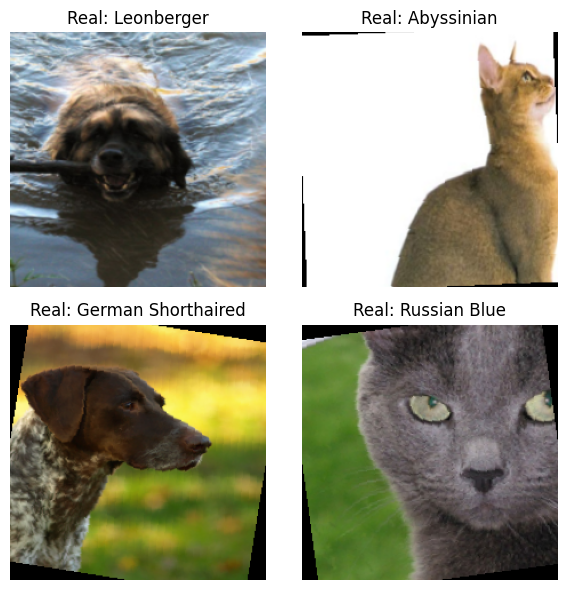

In [ ]:
show_samples(train_ds, n=4, title_prefix="Real: ")

# 4 - Image Captioning

Automatic captions are generated for training images using the BLIP model.
These captions will later be used for synthetic image generation.

In [ ]:
def pil_collate(batch):
    """Custom collate function: returns a list of PIL images and a tensor of labels."""
    # batch is a list of (image, label) pairs coming from the Dataset
    imgs, labels = zip(*batch)

    # Convert the labels tuple into a 1D LongTensor of shape [batch_size]
    labels = torch.tensor(labels, dtype=torch.long)

    # Keep images as a plain Python list of PIL.Image objects (no stacking here)
    return list(imgs), labels

# Transform for captioning: no ToTensor and no data augmentation
caption_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
])

# dataset for captioning using the original training subset (keeps original indices)
train_ds_caption = SafeTransformDataset(train_subset, caption_transform)

# DataLoader for captioning
caption_loader = DataLoader(
    train_ds_caption,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    collate_fn=pil_collate,
    pin_memory=False
)

In [ ]:
# BLIP model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
blip.eval()

gen_kwargs = {"max_length": 30, "num_beams": 4}

caption_records = []

for batch_idx, (pil_images, labels) in enumerate(
    tqdm(caption_loader, total=len(caption_loader))
):
    # pil_images: list of PIL.Image.Image
    # labels: tensor of shape [batch_size]

    inputs = processor(images=pil_images, return_tensors="pt").to(device)
    out_ids = blip.generate(**inputs, **gen_kwargs)
    captions = processor.batch_decode(out_ids, skip_special_tokens=True)

    for j, cap in enumerate(captions):
        # Compute the index in the original trainval dataset
        if hasattr(train_subset, "indices"):
            orig_idx = train_subset.indices[batch_idx * caption_loader.batch_size + j]
        else:
            orig_idx = batch_idx * caption_loader.batch_size + j

        record = {
            "image_id": int(orig_idx),
            "class_id": int(labels[j].item()),
            "class_name": trainval_base.classes[int(labels[j].item())],
            "caption": cap.strip(),
            "paraphrases": []
        }
        caption_records.append(record)

# save captions in a json
with open("train_captions.json", "w") as f:
    json.dump(caption_records, f, indent=2)

In [ ]:
show_caption_examples(caption_records, n=3)

Example 0
  Class:   Leonberger
  Caption: a dog swimming in the water with a stick in it ' s mouth

Example 1
  Class:   Abyssinian
  Caption: a cat sitting on the ground looking up

Example 2
  Class:   German Shorthaired
  Caption: a brown and white dog sitting on top of a lush green field



## 5. Text Paraphrasing (T5)

Generate 3 paraphrase variants per caption for prompt diversity.

In [ ]:
# T5 paraphrasing model (diverse, high-quality)
tokenizer = AutoTokenizer.from_pretrained(
    "ramsrigouthamg/t5-large-paraphraser-diverse-high-quality"
)
paraphrasing_model = AutoModelForSeq2SeqLM.from_pretrained(
    "ramsrigouthamg/t5-large-paraphraser-diverse-high-quality"
).to(device)

# load captions JSON (output of BLIP captioning)
with open("train_captions.json", "r") as f:
    data = json.load(f)

paraphrasing_model.eval()
len(data)

In [ ]:
# generate 3 paraphrases per caption
for i, img_data in enumerate(data):
    # get the original caption text for this image
    context = img_data.get("caption", "")
    if not context:
        img_data["paraphrases"] = []
        continue

    # prepend paraphrasing prefix required by the T5 model
    text = "paraphrase: " + context + " </s>"

    # tokenize the input text and create model inputs
    encoding = tokenizer.encode_plus(
        text,
        max_length=128,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )

    # move tokenized inputs to the target device
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    # generate multiple paraphrases using beam search
    beam_outputs = paraphrasing_model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=128,
        early_stopping=True,
        num_beams=5,
        num_return_sequences=3
    )

    paraphrases = []
    for beam_output in beam_outputs:
        # decode token IDs back to plain text
        sent = tokenizer.decode(
            beam_output,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=True
        )
        # remove any extra prefix the model may add
        sent = sent.replace("paraphrasedoutput:", "").strip()
        paraphrases.append(sent)

    # store generated paraphrases in the current record
    img_data["paraphrases"] = paraphrases

In [ ]:
# save extended captions with paraphrases
with open("train_captions_with_paraphrases.json", "w") as f:
    json.dump(data, f, indent=2)

print(f"Saved paraphrases for {len(data)} images.")

In [ ]:
# load directly instead of recomputing
with open("train_captions_with_paraphrases.json", "r") as f:
    data = json.load(f)

print(f"Loaded paraphrases for {len(data)} images.")
show_caption_examples(data, n=3)

Loaded paraphrases for 2944 images.
Example 0
  Class:   Leonberger
  Caption: a dog swimming in the water with a stick in it ' s mouth
  Paraphrase 1: A dog with a stick in it's mouth is dipping in the water.
  Paraphrase 2: A dog with a stick in it's mouth is swimming in the water.
  Paraphrase 3: A dog with a stick stuck in it's mouth is dipping in the water.

Example 1
  Class:   Abyssinian
  Caption: a cat sitting on the ground looking up
  Paraphrase 1: A cat on the ground looking up.
  Paraphrase 2: A cat that was sitting on the ground looking up.
  Paraphrase 3: A cat is seen on the ground looking up.

Example 2
  Class:   German Shorthaired
  Caption: a brown and white dog sitting on top of a lush green field
  Paraphrase 1: On top of a lush green field, a brown and white dog stands on top.
  Paraphrase 2: A brown and white dog stands on top of a lush green field.
  Paraphrase 3: On top of a lush green field, a brown and white dog sits on top.



## 6. Synthetic Image Generation (Stable Diffusion)

Generate ~300 synthetic images.
To ensure that the synthetic data generation could be completed within the
memory and time constraints of the Google Colab environment, the generation
process was deliberately constrained. The number of source images and the number of textual prompts per image were
limited to control memory usage and execution time. The number of diffusion
steps was reduced to balance image quality and computational cost, while the
guidance scale was kept at a standard Stable Diffusion value to preserve
prompt fidelity.

In [ ]:
# limit number of source images
MAX_RECORDS = 300
# fewer steps for faster generation
NUM_STEPS = 25
# standard guidance
GUIDANCE = 7.5

In [ ]:
# Stable Diffusion model identifier on Hugging Face
sd_model = "CompVis/stable-diffusion-v1-4"

# output directory where synthetic images will be saved
out_dir = Path("data_synth")
out_dir.mkdir(exist_ok=True)

# use half precision on GPU to save memory, full precision on CPU
torch_dtype = torch.float16 if device == "cuda" else torch.float32

# load the Stable Diffusion pipeline with the chosen dtype
sd_pipeline = StableDiffusionPipeline.from_pretrained(sd_model, torch_dtype=torch_dtype)
# reduce memory usage by slicing attention computation
sd_pipeline.enable_attention_slicing()
sd_pipeline = sd_pipeline.to(device)

In [ ]:
with open("train_captions_with_paraphrases.json", "r", encoding="utf-8") as f:
    data = json.load(f)

In [ ]:
# simple list to store metadata for all generated images
meta_all = []

data = data[:MAX_RECORDS]  # limit the number of records to generate

for rec in tqdm(data, desc="generating"):
    img_class = rec["class_name"]  # target class name for this image

    # directory for this class (one subfolder per class)
    class_dir = out_dir / img_class
    class_dir.mkdir(parents=True, exist_ok=True)

    # build a small list of texts: caption + paraphrases
    texts = [rec.get("caption", "")] + rec.get("paraphrases", [])
    texts = [t for t in texts if isinstance(t, str) and t.strip()]
    # use at most two prompts per record
    texts = texts[:2]

    # use image_id (if present) to derive a reproducible random seed
    base_id = rec.get("image_id", None)
    for k, t in enumerate(texts):
        # simple varying seed based on base_id and index
        seed = (int(base_id) if base_id is not None else 0) + k + 42
        gen = torch.Generator(device=device).manual_seed(seed)

        # build the text prompt for Stable Diffusion
        prompt = f"photo of a {img_class}, {t}"
        try:
            out = sd_pipeline(
                prompt,
                num_inference_steps=NUM_STEPS,
                guidance_scale=GUIDANCE,
                generator=gen
            )
            image = out.images[0]
        except Exception as e:
            print(f"Generation failed for id={base_id} prompt='{prompt[:80]} ': {e}")
            continue

        # save image to disk inside the class-specific folder
        fname = class_dir / f"{rec.get('image_id','na')}_{k}_s{seed}.png"
        image.save(str(fname))

        # store metadata for later use (dataset loading, analysis, etc.)
        meta_all.append({
            "image_id": rec.get("image_id"),
            "class": img_class,
            "prompt": prompt,
            "seed": int(seed),
            "path": str(fname)
        })

# save all metadata to a JSON file
with open(out_dir / "generated_img_metadata.json", "w", encoding="utf-8") as mf:
    json.dump(meta_all, mf, indent=2, ensure_ascii=False)

print("Done. Generated images:", len(meta_all))

# 7 - Training with Extended Dataset

The original training set is extended with synthetic images.
The validation and test sets remain unchanged and consist only of real data.


In [ ]:
# base dataset for synthetic images (folders = class names)
synth_base = ImageFolder(
    root="/content/drive/MyDrive/Colab Notebooks/data_synth",
    transform=None  # transforms are applied later via SafeTransformDataset
)

# ensure class names and ordering match the original training dataset
assert synth_base.classes == train_ds.classes, "Class names/order mismatch between real and synthetic datasets."

In [ ]:
# apply the same training transforms to the synthetic images
synth_ds = SafeTransformDataset(synth_base, transform_train)

# concatenate original training set and synthetic set into a single dataset
train_extended_ds = ConcatDataset([train_ds, synth_ds])

# DataLoader for the extended training dataset
train_extended_loader = DataLoader(
    train_extended_ds,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

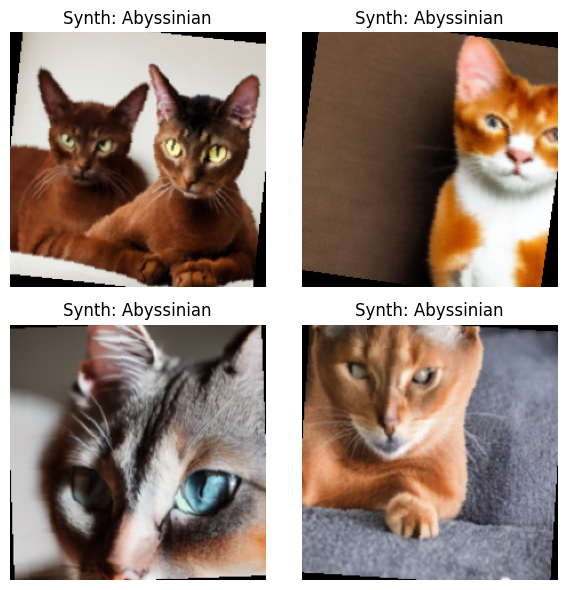

In [ ]:
show_samples(synth_ds, n=4, title_prefix="Synth: ")

## 8 - ResNet-18 Results

In [ ]:
# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

num_classes = len(train_ds.classes)

# Baseline ResNet-18
resnet_baseline = models.resnet18(pretrained=True)
resnet_baseline.fc = nn.Linear(resnet_baseline.fc.in_features, num_classes)
resnet_baseline = resnet_baseline.to(device)

criterion_base = nn.CrossEntropyLoss()
optimizer_base = torch.optim.Adam(resnet_baseline.parameters(), lr=3e-4)
scheduler_base = torch.optim.lr_scheduler.StepLR(optimizer_base, step_size=3, gamma=0.1)

history_baseline = train_model(
    resnet_baseline,
    train_loader,
    val_loader,
    criterion_base,
    optimizer_base,
    scheduler_base,
    device,
    num_epochs=10,
    train_size=len(train_ds),
    num_classes=num_classes
)

baseline_results = evaluate(resnet_baseline, test_loader, num_classes=num_classes)
print_full_metrics("ResNet-18 Baseline (Test)", baseline_results)

Epoch 0: Train Loss=1.7474, Train Acc=0.5401, Val Acc=0.6739
Epoch 1: Train Loss=0.9990, Train Acc=0.7143, Val Acc=0.7065
Epoch 2: Train Loss=0.8753, Train Acc=0.7439, Val Acc=0.6875
Epoch 3: Train Loss=0.6928, Train Acc=0.8132, Val Acc=0.8410
Epoch 4: Train Loss=0.5583, Train Acc=0.8488, Val Acc=0.8573
Epoch 5: Train Loss=0.5083, Train Acc=0.8618, Val Acc=0.8601
Epoch 6: Train Loss=0.4977, Train Acc=0.8679, Val Acc=0.8628
Epoch 7: Train Loss=0.4934, Train Acc=0.8689, Val Acc=0.8614
Epoch 8: Train Loss=0.4594, Train Acc=0.8760, Val Acc=0.8641
Epoch 9: Train Loss=0.4647, Train Acc=0.8808, Val Acc=0.8655


ResNet-18 Baseline (Test)
  Accuracy:        0.8376
  Macro Precision: 0.8478
  Macro Recall:    0.8370
  Macro F1:        0.8344



### Short result summary ResNet‑18 Baseline

The baseline ResNet‑18 reaches an overall test accuracy of about 83.8%, with macro precision, recall and F1 all around 0.84. This indicates that the model performs consistently across most classes, but there is still room for improvement on some minority or harder categories.

In [ ]:
# Extended ResNet-18
resnet_extended = models.resnet18(pretrained=True)
resnet_extended.fc = nn.Linear(resnet_extended.fc.in_features, num_classes)
resnet_extended = resnet_extended.to(device)

criterion_ext = nn.CrossEntropyLoss()
optimizer_ext = torch.optim.Adam(resnet_extended.parameters(), lr=3e-4)
scheduler_ext = torch.optim.lr_scheduler.StepLR(optimizer_ext, step_size=3, gamma=0.1)

history_extended = train_model(
    resnet_extended,
    train_extended_loader,
    val_loader,
    criterion_ext,
    optimizer_ext,
    scheduler_ext,
    device,
    num_epochs=10,
    train_size=len(train_extended_ds),
    num_classes=num_classes
)

extended_results = evaluate(resnet_extended, test_loader, num_classes=num_classes)
print_full_metrics("ResNet-18 Extended (Test)", extended_results)

Epoch 0: Train Loss=1.6929, Train Acc=0.5533, Val Acc=0.6603
Epoch 1: Train Loss=1.0749, Train Acc=0.6893, Val Acc=0.7228
Epoch 2: Train Loss=0.9013, Train Acc=0.7376, Val Acc=0.7541
Epoch 3: Train Loss=0.6781, Train Acc=0.8157, Val Acc=0.8451
Epoch 4: Train Loss=0.5937, Train Acc=0.8361, Val Acc=0.8560
Epoch 5: Train Loss=0.5298, Train Acc=0.8541, Val Acc=0.8573
Epoch 6: Train Loss=0.4987, Train Acc=0.8623, Val Acc=0.8587
Epoch 7: Train Loss=0.5041, Train Acc=0.8657, Val Acc=0.8560
Epoch 8: Train Loss=0.4847, Train Acc=0.8710, Val Acc=0.8641
Epoch 9: Train Loss=0.4866, Train Acc=0.8648, Val Acc=0.8587


ResNet-18 Extended (Test)
  Accuracy:        0.8397
  Macro Precision: 0.8492
  Macro Recall:    0.8392
  Macro F1:        0.8375



### Short result summary ResNet‑18 Extended

When trained on the extended dataset with synthetic images, ResNet‑18 achieves a very similar test accuracy around 83.9%, with only marginal gains in macro precision, recall and F1. This suggests that the current synthetic data configuration does not substantially change the overall performance of this backbone on real test images.

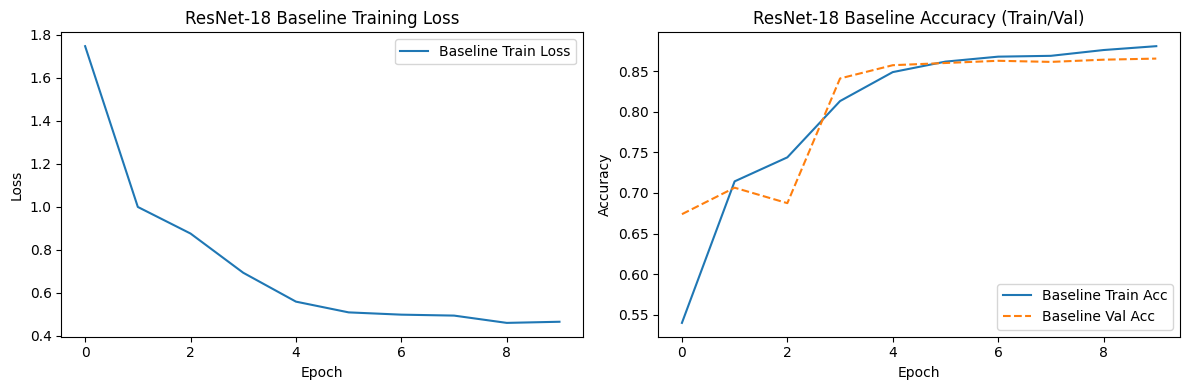

In [ ]:
plot_training_curves({"Baseline": history_baseline}, title_prefix="ResNet-18 Baseline ")

###  ResNet‑18 Baseline curves

Training loss decreases steadily and the gap between training and validation accuracy remains moderate, indicating good convergence without strong overfitting. The validation accuracy plateaus after a few epochs, suggesting that longer training would likely not yield large additional gains.

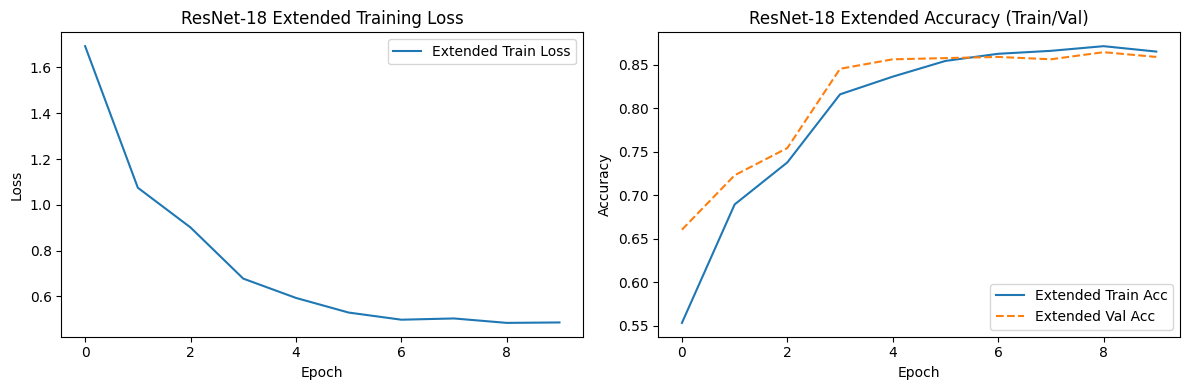

In [ ]:
plot_training_curves({"Extended": history_extended}, title_prefix="ResNet-18 Extended ")

### ResNet‑18 Extended curves

With the extended dataset, training loss starts higher but follows a similar decreasing trend, while validation accuracy tracks the baseline closely. This shows that adding synthetic images makes optimization slightly harder at the beginning but does not significantly alter the final generalization behaviour on real data.

## 9 - EfficientNet-B0 Results

In [ ]:
# EfficientNet-B0 Baseline
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
effnet_baseline = efficientnet_b0(weights=weights)
effnet_baseline.classifier[1] = nn.Linear(
    effnet_baseline.classifier[1].in_features,
    num_classes
)
effnet_baseline = effnet_baseline.to(device)

criterion_eff_base = nn.CrossEntropyLoss()
optimizer_eff_base = torch.optim.Adam(effnet_baseline.parameters(), lr=3e-4)
scheduler_eff_base = torch.optim.lr_scheduler.StepLR(optimizer_eff_base, step_size=3, gamma=0.1)

history_effnet_baseline = train_model(
    effnet_baseline,
    train_loader,
    val_loader,
    criterion_eff_base,
    optimizer_eff_base,
    scheduler_eff_base,
    device,
    num_epochs=10,
    train_size=len(train_ds),
    num_classes=num_classes
)

effnet_baseline_results = evaluate(effnet_baseline, test_loader, num_classes=num_classes)
print_full_metrics("EfficientNet-B0 Baseline (Test)", effnet_baseline_results)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 85.4MB/s]


Epoch 0: Train Loss=2.2098, Train Acc=0.4959, Val Acc=0.8125
Epoch 1: Train Loss=0.8746, Train Acc=0.7510, Val Acc=0.8560
Epoch 2: Train Loss=0.6630, Train Acc=0.8162, Val Acc=0.8682
Epoch 3: Train Loss=0.5720, Train Acc=0.8400, Val Acc=0.8940
Epoch 4: Train Loss=0.5091, Train Acc=0.8543, Val Acc=0.9035
Epoch 5: Train Loss=0.4758, Train Acc=0.8645, Val Acc=0.9008
Epoch 6: Train Loss=0.4713, Train Acc=0.8675, Val Acc=0.8967
Epoch 7: Train Loss=0.4749, Train Acc=0.8668, Val Acc=0.9049
Epoch 8: Train Loss=0.4536, Train Acc=0.8723, Val Acc=0.8995
Epoch 9: Train Loss=0.4585, Train Acc=0.8709, Val Acc=0.9008


EfficientNet-B0 Baseline (Test)
  Accuracy:        0.8855
  Macro Precision: 0.8884
  Macro Recall:    0.8847
  Macro F1:        0.8828



### Short result summary EfficientNet-B0 Baseline
The baseline EfficientNet‑B0 achieves about 88.6% test accuracy, outperforming ResNet‑18 on the same real only training set. The higher macro precision, recall and F1 show that this architecture handles fine‑grained pet categories more effectively across classes.

In [ ]:
# EfficientNet-B0 Extended
effnet_extended = efficientnet_b0(weights=weights)
effnet_extended.classifier[1] = nn.Linear(
    effnet_extended.classifier[1].in_features,
    num_classes
)
effnet_extended = effnet_extended.to(device)

criterion_eff_ext = nn.CrossEntropyLoss()
optimizer_eff_ext = torch.optim.Adam(effnet_extended.parameters(), lr=3e-4)
scheduler_eff_ext = torch.optim.lr_scheduler.StepLR(optimizer_eff_ext, step_size=3, gamma=0.1)

history_effnet_extended = train_model(
    effnet_extended,
    train_extended_loader,
    val_loader,
    criterion_eff_ext,
    optimizer_eff_ext,
    scheduler_eff_ext,
    device,
    num_epochs=10,
    train_size=len(train_extended_ds),
    num_classes=num_classes
)

effnet_extended_results = evaluate(effnet_extended, test_loader, num_classes=num_classes)
print_full_metrics("EfficientNet-B0 Extended (Test)", effnet_extended_results)

Epoch 0: Train Loss=2.0481, Train Acc=0.5237, Val Acc=0.8329
Epoch 1: Train Loss=0.8525, Train Acc=0.7593, Val Acc=0.8886
Epoch 2: Train Loss=0.6811, Train Acc=0.7971, Val Acc=0.8845
Epoch 3: Train Loss=0.5436, Train Acc=0.8448, Val Acc=0.9035
Epoch 4: Train Loss=0.5077, Train Acc=0.8569, Val Acc=0.9103
Epoch 5: Train Loss=0.4634, Train Acc=0.8651, Val Acc=0.9212
Epoch 6: Train Loss=0.4632, Train Acc=0.8679, Val Acc=0.9239
Epoch 7: Train Loss=0.4716, Train Acc=0.8688, Val Acc=0.9171
Epoch 8: Train Loss=0.4602, Train Acc=0.8727, Val Acc=0.9212
Epoch 9: Train Loss=0.4528, Train Acc=0.8722, Val Acc=0.9185


EfficientNet-B0 Extended (Test)
  Accuracy:        0.8863
  Macro Precision: 0.8888
  Macro Recall:    0.8858
  Macro F1:        0.8848



### Short result summary EfficientNet-B0 Extended

With synthetic images included, EfficientNet‑B0 slightly improves to around 88.6–88.7% test accuracy, with small but consistent gains in macro F1. This indicates that generative augmentation is mostly neutral but can provide a mild benefit for a stronger backbone that already generalizes well.


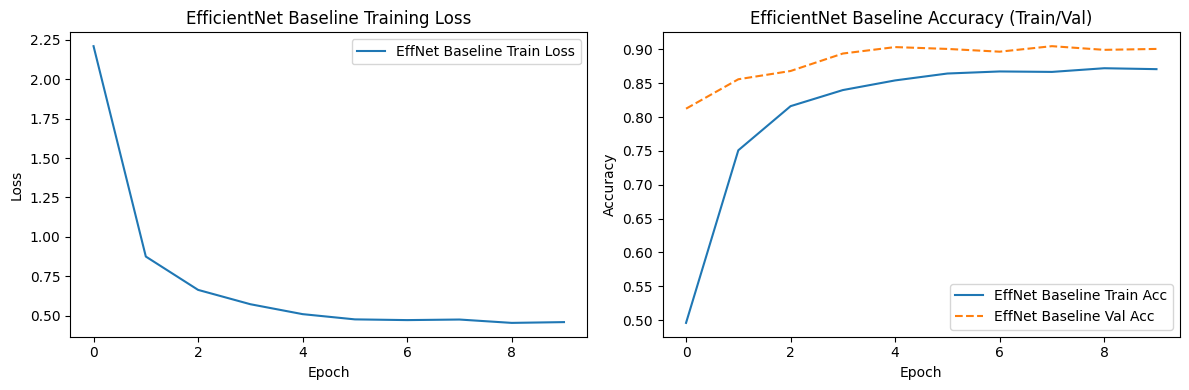

In [ ]:
plot_training_curves({"EffNet Baseline": history_effnet_baseline}, title_prefix="EfficientNet Baseline ")

### EfficientNet‑B0 Baseline curves

The baseline EfficientNet‑B0 shows a rapid drop in loss and a fast increase in validation accuracy within the first epochs. The training and validation curves remain close, pointing to a good balance between capacity and regularization on the real dataset.

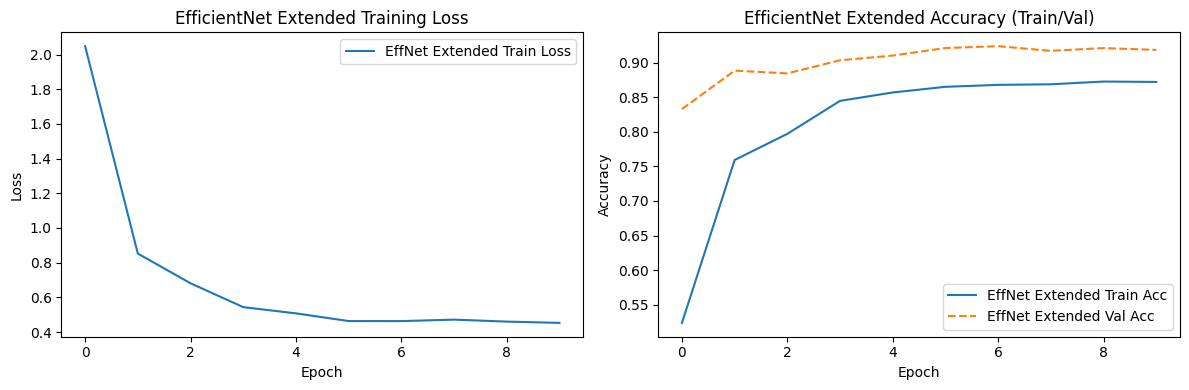

In [ ]:
plot_training_curves({"EffNet Extended": history_effnet_extended}, title_prefix="EfficientNet Extended ")

### EfficientNet‑B0 Extended curves
Using the extended dataset, EfficientNet‑B0 exhibits very similar learning curves, with slightly higher validation accuracy in the later epochs. This behaviour suggests that synthetic images mainly act as a mild regularizer rather than dramatically changing the learning dynamics

# Overall comparison

Generating captions, paraphrases and text‑to‑image samples allowed the construction of an extended training set that remains fully compatible with the original Oxford‑IIIT Pet labels. While synthetic images do not dramatically change test performance, they are able to slightly boost strong models such as EfficientNet‑B0 and provide a controlled way to study data augmentation strategies for critical‑infrastructure‑like vision tasks.

---

## 📚 References & Resources

- [Image Captioning using PyTorch and Transformers in Python](https://eranfeit.net/image-captioning-using-pytorch-and-transformers-in-python/)

- [Image captioning](https://huggingface.co/docs/transformers/main/tasks/image_captioning)

- [Image Captioning with PyTorch Using Transformers](https://medium.com/@omeraykilic1905/image-captioning-with-pytorch-using-transformers-36523d516782)

- [Paraphrase-Generation](https://huggingface.co/Vamsi/T5_Paraphrase_Paws)

- [Text Data Augmentation using Paraphrasing](https://www.youtube.com/watch?v=EDh-FQ7mxGE)

- [How to paraphrase text in Python using transformers](https://www.youtube.com/watch?v=zGK9ZfvRRoM)

- [Text-to-image](https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/text2img)

- [Text-to-Image with Stable Diffusion: From Theory to Production](https://medium.com/@amitkharche14/text-to-image-with-stable-diffusion-from-theory-to-production-72320b43ed55)

- Various YouTube videos

- ChatGPT – used for improving documentation clarity and polishing markdown sections
